На это семинаре будет необходимо (1) реализовать Dropout-слой и проследить его влияние на обобщающую способность сети (2) реализовать BatchNormalization-слой и пронаблюдать его влияние на скорость сходимости обучения.

## Dropout (0.6 балла)

Как всегда будем экспериментировать на датасете MNIST. MNIST является стандартным бенчмарк-датасетом, и его можно подгрузить средствами pytorch.

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [38]:
input_size = 784
num_classes = 10
batch_size = 128

train_dataset = dsets.MNIST(root='./MNIST/', 
                                   train=True, 
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.MNIST(root='./MNIST/', 
                                  train=False, 
                                  transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Определим ряд стандартных функций с прошлых семинаров

In [39]:
def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        data = x_batch
        target = y_batch

        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target).cpu()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log    

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):    
        data = x_batch
        target = y_batch

        output = model(data)
        loss = F.nll_loss(output, target).cpu()

        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, batchsize=batch_size)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))
        
        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')   
        
        print("Epoch: {2}, val loss: {0}, val accuracy: {1}".format(np.mean(val_loss), np.mean(val_acc), epoch))


Создайте простейшую однослойную модель - однослойную полносвязную сеть и обучите ее с параметрами оптимизации, заданными ниже.

In [40]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)
    
model = nn.Sequential(
    Flatten(),
    nn.Linear(input_size, num_classes),
    nn.LogSoftmax(dim=-1)
    )

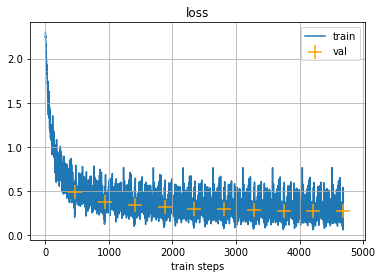

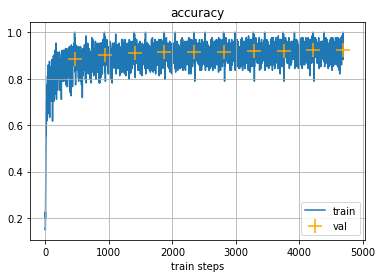

Epoch: 9, val loss: 0.2751225531101227, val accuracy: 0.9228639006614685


In [41]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
train(model, opt, 10)

Параметром обученной нейросети является матрица весов, в которой каждому классу соответствует один из 784-мерных столбцов. Визуализируйте обученные векторы для каждого из классов, сделав их двумерными изображениями 28-28. Для визуализации можно воспользоваться кодом для визуализации MNIST-картинок с предыдущих семинаров.

In [42]:
list(model.parameters())[0]

Parameter containing:
tensor([[-0.0289, -0.0259, -0.0249,  ..., -0.0167, -0.0168,  0.0262],
        [ 0.0269,  0.0286,  0.0269,  ..., -0.0236, -0.0297,  0.0098],
        [-0.0142,  0.0017, -0.0092,  ..., -0.0144,  0.0285,  0.0121],
        ...,
        [ 0.0078,  0.0002,  0.0284,  ...,  0.0033, -0.0274,  0.0347],
        [ 0.0258,  0.0227, -0.0123,  ...,  0.0044, -0.0072,  0.0270],
        [-0.0037,  0.0285,  0.0004,  ..., -0.0162, -0.0034,  0.0125]],
       requires_grad=True)

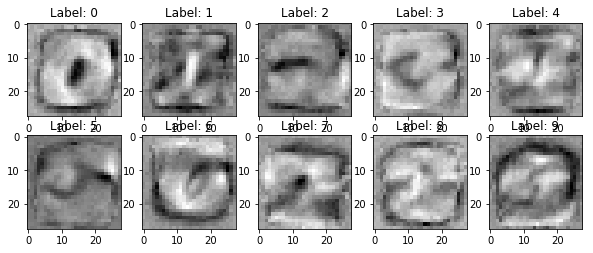

In [43]:
weights = [w.detach().numpy() for w in list(model.parameters())[0]]
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

Реализуйте Dropout-слой для полносвязной сети. Помните, что этот слой ведет себя по-разному во время обучения и во время применения. 

In [47]:
class DropoutLayer(nn.Module):
    def __init__(self, p):
        super().__init__()
        #<your code>
        self.p = p
        
    def forward(self, input):
        if self.training:
            #<your code>
            return torch.Tensor(np.random.binomial(1, 1 - self.p, input.shape)) * input
        else:
            #<your code>
            return input * (1 - self.p + 1e-8)

Добавьте Dropout-слой в архитектуру сети, проведите оптимизацию с параметрами, заданными ранее, визуализируйте обученные веса. Есть ли разница между весами обученными с Dropout и без него? Параметр Dropout возьмите равным 0.7

In [48]:
modelDp = nn.Sequential(
    #<your code>
    Flatten(),
    DropoutLayer(0.7),
    nn.Linear(input_size, num_classes),
    nn.LogSoftmax(dim=-1)
    )

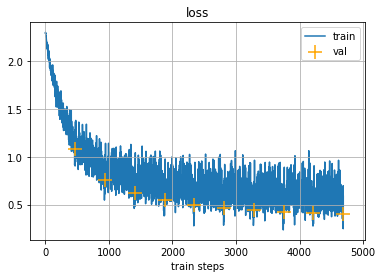

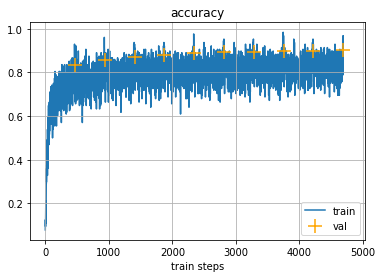

Epoch: 9, val loss: 0.40257236408659175, val accuracy: 0.9009097814559937


In [49]:
opt = torch.optim.Adam(modelDp.parameters(), lr=0.0005)
train(modelDp, opt, 10)

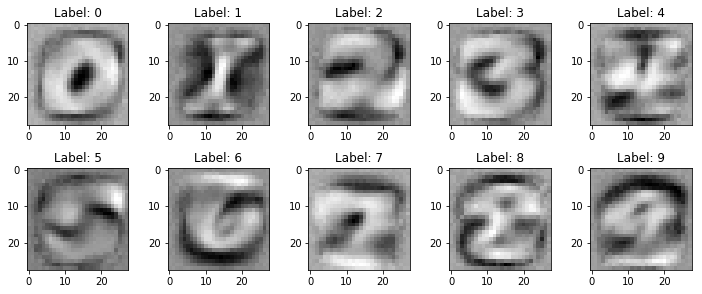

In [50]:
weights = [w.detach().numpy() for w in list(modelDp.parameters())[0]]
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray')
    plt.tight_layout()

#### Наблюдения:
Можно наблюдать, что графические изображения весов стали принимать более четкие очертания цифр. Из этого можно предположить, что происходит меньшее переобучение на шум в данных, чем без применения DropOut.

Обучите еще одну модель, в которой вместо Dropout-регуляризации используется L2-регуляризация с коэффициентом 0.05. (Параметр weight_decay в оптимизаторе). Визуализируйте веса и сравните с двумя предыдущими подходами.

In [51]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(input_size,num_classes),
    nn.LogSoftmax(dim=-1)
    )

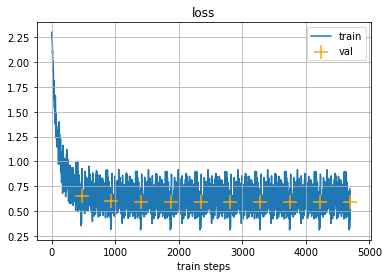

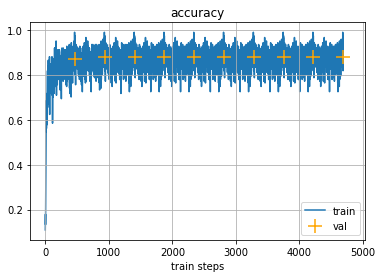

Epoch: 9, val loss: 0.5904750373167328, val accuracy: 0.8812302350997925


In [52]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.05)
train(model, opt, 10)

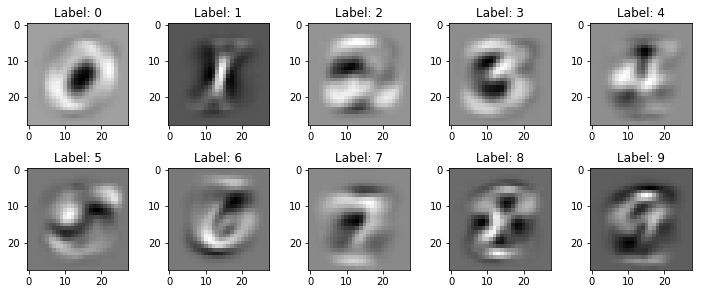

In [53]:
weights = [w.detach().numpy() for w in list(model.parameters())[0]]
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray')
    plt.tight_layout()

Наблюдаем более "узкие" и в целом более серые изображения. Можно объяснить тем, что мы минимизируем норму вектора.

## Batch normalization (0.4 балла)

Реализуйте BatchNormalization слой для полносвязной сети. В реализации достаточно только центрировать и разделить на корень из дисперсии, аффинную поправку (гамма и бета) в этом задании можно не реализовывать.

In [32]:
class BnLayer(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        #<your code>
        self.num_features = num_features
        self.running_mean = torch.zeros(self.num_features)
        self.running_var = torch.ones(self.num_features)
        self.momentum = 0.9

    def forward(self, input):
        if self.training:
            #<your code>
            mean = torch.mean(input, dim=0)
            var = torch.std(input, dim=0)
            self.running_mean = self.running_mean * (1 - self.momentum) + mean * self.momentum
            self.running_var = self.running_var * (1 - self.momentum) + var * self.momentum
            return (input - mean) / (var + 1e-8)
        else:
            #<your code>
            return (input - self.running_mean) / (self.running_var + 1e-8)

Обучите трехслойную полносвязную сеть (размер скрытого слоя возьмите 100) с сигмоидами в качестве функций активации. 

In [33]:
hidden_size = 100
model = nn.Sequential(
    #<your code>
    Flatten(),
    nn.Linear(input_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, num_classes),
    nn.LogSoftmax(dim=-1),
    )

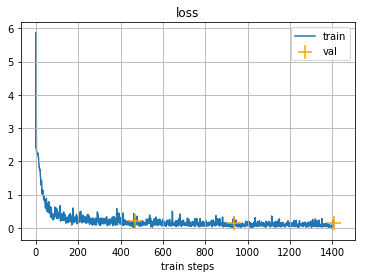

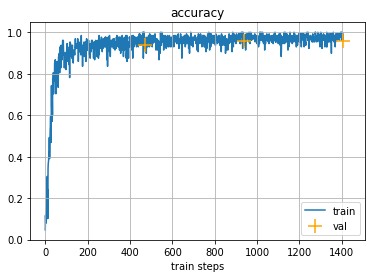

Epoch: 2, val loss: 0.13448804961163788, val accuracy: 0.9584652185440063


In [34]:
opt = torch.optim.RMSprop(model.parameters(), lr=0.01)
train(model, opt, 3)

Повторите обучение с теми же параметрами для сети с той же архитектурой, но с добавлением BatchNorm слоя (для всех трех скрытых слоев).

In [35]:
modelBN = nn.Sequential(
    #<your code>
    Flatten(),
    nn.Linear(input_size, hidden_size),
    BnLayer(hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, hidden_size),
    BnLayer(hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, num_classes),
    BnLayer(num_classes),
    nn.LogSoftmax(dim=-1)
)

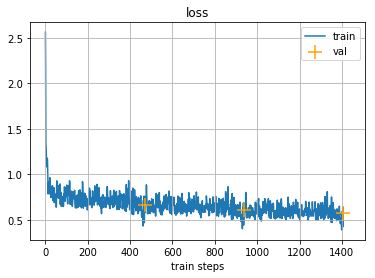

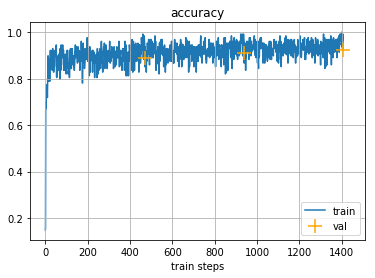

Epoch: 2, val loss: 0.5734770177285883, val accuracy: 0.9254351258277893


In [36]:
opt = torch.optim.RMSprop(modelBN.parameters(), lr=0.01)
train(modelBN, opt, 3)

Сравните кривые обучения и сделайте вывод о влиянии BatchNorm на ход обучения.

Модель с применением BatchNorm быстрее сошлась к лучшей точности и меньшим значениям функции потерь. Однако, дальнейшее обучение менее стабильно, чем при обучении без применения данной нормализации.